# Human Activity Recognition - Federated Learning

#### Author : Willy Fitra Hendria (willyfitrahendria@gmail.com)

## 1. Theory


Federated Learning is a machine learning technique where the data is distributed among different client machines. As shown in Figure 1, the training process is done in each client using its own local data. The global model only need to know the client's model, but doesn't need to know the client's data. Since there is no sharing data from client, it allow us to tackle problems in data privacy & security.

![image](https://raw.githubusercontent.com/willyfh/human-activity-recognition-federated-learning/main/images/federated%20learning.png)

<sup>Figure 1: Federaterd Averaging Algorithm 1 (Source: McMahan, B., Moore, E., Ramage, D., Hampson, S. and y Arcas, B.A., 2017, April. Communication-efficient learning of
deep networks from decentralized data. In Artificial Intelligence and Statistics (pp. 1273-1282). PMLR)</sup>

In a smart factory, the manufacturing performance can be improved using machine learning algorithms. Unfortunately a single factory may not have enough data to build a good machine learning model. Despite the case of limited data, the companies often don't want to share data with other companies. With federated learning techniques, smart factories would be able to build a better model to improve the performance, without having to worry about data privacy.

## 2. Implementation
Basically the following implementation can be executed step by step.

Please see the details explanation of each step in the respective section accordingly.

### Mounting to Gdrive
Before mounting, put the dataset into your google drive

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive/', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/


### Parameters

Please pay attention to the following parameters. You may need to change the values depending on your case. **work_dir** is the location of DBALab-Test in your gdrive, and **data** is a dataset folder (**Preprocessed** or **Raw Data**) inside the **work_dir**. Here, only **Preprocessed** dataset is used.

In [4]:
work_dir = "drive/My Drive/hufs/DBALab-Test/" # dataset location in gdrive
data = "Preprocessed/*csv" # here Preprocessed data is used
n_clients = 8 # number of clients / federated members
n_rounds = 7
epochs = 1 # local epoch
batch_size = 32
window_size = 10 # window size of dataset
window_step = 1

### Import libraries

In [5]:
import glob
import os
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

### Set the random seed for reproducibility

In [6]:
def seed_torch(seed=0):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  #torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch()

### Load dataset

In [7]:
data_files = glob.glob(work_dir+data)
data_files.sort()

In [8]:
# load and combine all data
df_from_each_file = (pd.read_csv(f, names=np.arange(1, 23)) for f in tqdm(data_files))
df = pd.concat(df_from_each_file, ignore_index=True)

100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


In [9]:
df.shape

(1056870, 22)

### Visualize a sample of data
Here, I visualize a single file of the dataset (mHealth_subject1.csv)

drive/My Drive/hufs/DBALab-Test/Preprocessed/mHealth_subject1.csv


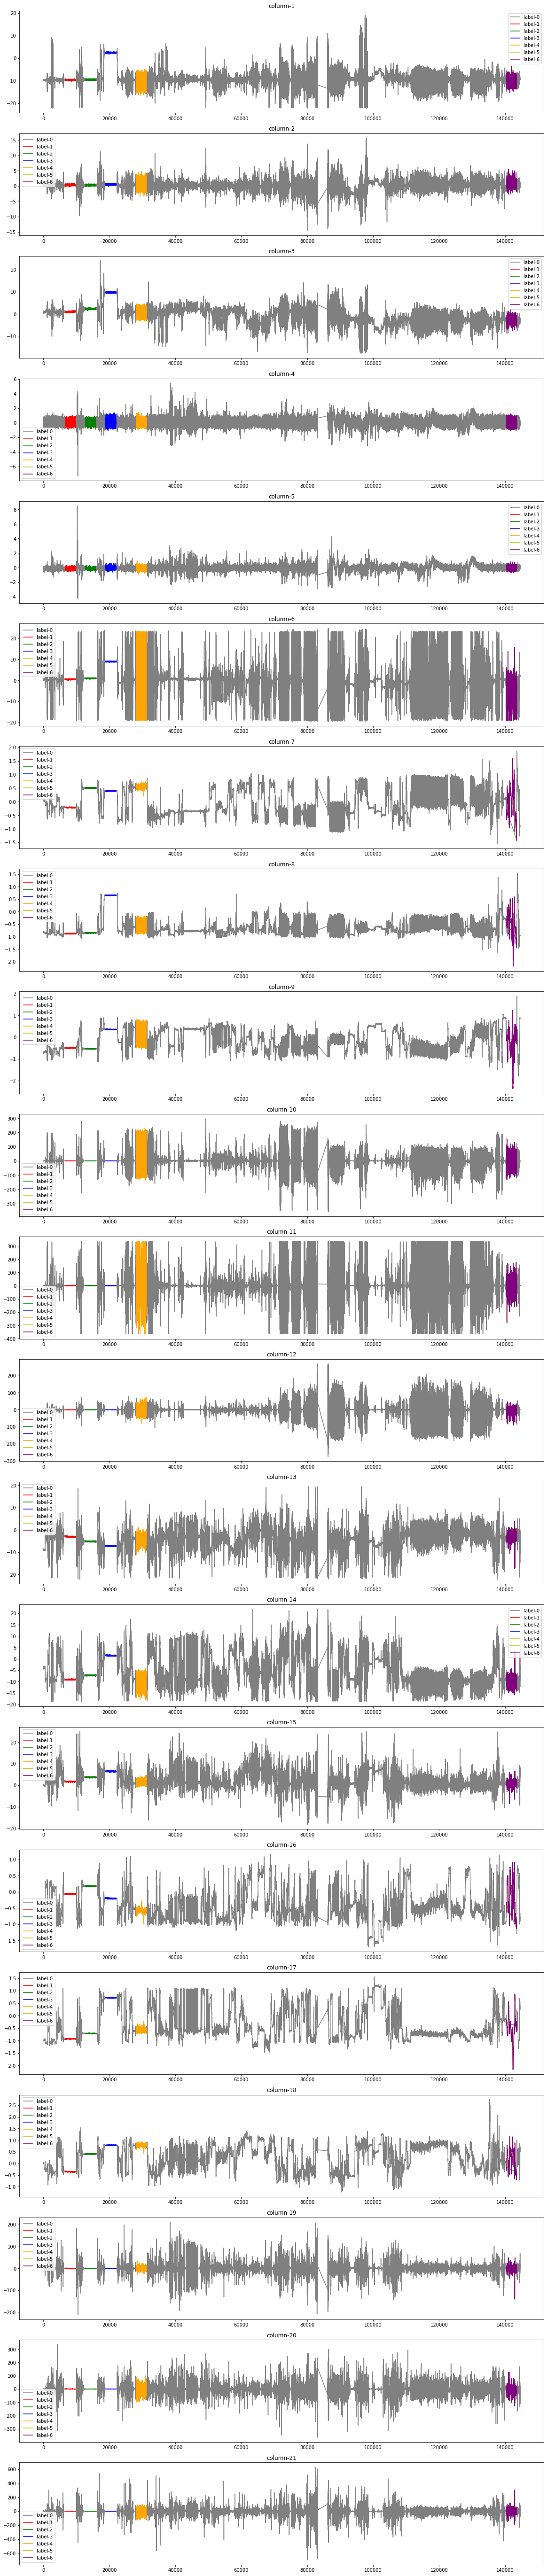

In [10]:
print(data_files[0])
sample_df = pd.read_csv(data_files[0],  names=np.arange(1, 23))
fig, ax = plt.subplots(21 , 1, figsize=(20, 100), facecolor='w', edgecolor='k')

for i in range(1,22):
  legend = True
  sample_df[sample_df[22]==0].plot(y=i, color="gray", ax=ax[i-1], label='label-0', legend=legend, title='column-{}'.format(i))
  sample_df[sample_df[22]==1].plot(y=i, color="r", ax=ax[i-1], label='label-1', legend=legend)
  sample_df[sample_df[22]==2].plot(y=i, color="g", ax=ax[i-1], label='label-2', legend=legend)
  sample_df[sample_df[22]==3].plot(y=i, color="b", ax=ax[i-1], label='label-3', legend=legend)
  sample_df[sample_df[22]==4].plot(y=i, color="orange", ax=ax[i-1], label='label-4', legend=legend)
  sample_df[sample_df[22]==5].plot(y=i, color="y", ax=ax[i-1], label='label-5', legend=legend)
  sample_df[sample_df[22]==5].plot(y=i, color="purple", ax=ax[i-1], label='label-6', legend=legend)


### Distribution
Excluding the null activity, the distribution is perfectly balanced.

**Assumption**: *I'm allowed to remove the null class (0)*.

Hence, I remove the null class in this experiment.

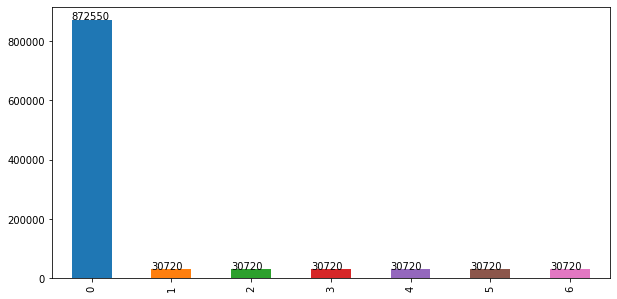

In [11]:
ax = df[22].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), color=sn.color_palette())
for p in ax.patches:
  ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

Here, I remove the null class, and shift the value so the label still started from zero.

In [12]:
df = df[df[22] != 0] # remove null class
df[22] = df[22] -1 # shift the label value

Now this is the distribution after removing the null class

In [13]:
df[22].value_counts()

5    30720
4    30720
3    30720
2    30720
1    30720
0    30720
Name: 22, dtype: int64

### Standardize the dataset

By looking at the following statistics, the data is not standardized yet.

In [12]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
count,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.000000,184320.00000,184320.000000,184320.00000
mean,-7.511100,-0.815354,0.750997,2.127939,-7.798748,0.322010,0.193297,-0.455139,0.007584,0.439447,-3.025780,-0.171436,-4.224604,-5.741578,2.126556,-0.244089,-0.315659,0.449952,-1.084268,1.34691,0.482406,2.50000
std,5.654398,2.726074,4.506984,4.218175,6.226101,6.939615,0.445786,0.530110,0.550885,85.441405,51.395722,22.000718,5.590096,6.800310,3.996105,0.509272,0.573753,0.481672,32.579124,29.56581,93.462334,1.70783
min,-22.438000,-20.188000,-18.392000,-22.146000,-19.600000,-19.373000,-1.779200,-2.660400,-2.626700,-357.560000,-364.570000,-282.390000,-22.015000,-18.972000,-18.238000,-1.170600,-2.256700,-1.114200,-319.030000,-354.42000,-702.570000,0.00000
25%,-9.768700,-1.683525,-1.747200,0.113445,-9.947500,-2.324500,-0.111320,-0.786120,-0.495090,-15.999750,-5.671375,-0.875420,-6.609100,-9.538700,0.197180,-0.692160,-0.759750,0.008621,-1.837725,-1.74035,-2.909700,1.00000
50%,-9.173450,-0.797900,-0.177170,1.474900,-9.465300,0.623440,0.352500,-0.639770,0.098232,0.185000,0.546630,-0.303300,-3.079850,-8.040200,1.704650,-0.313730,-0.533880,0.596980,0.360810,0.35217,-0.709300,2.50000
75%,-4.277000,0.360385,2.480950,3.433550,-1.382175,4.286225,0.536180,-0.300190,0.447940,0.550780,0.735580,0.332883,-1.742575,-1.750200,4.124500,0.109800,0.170430,0.855600,0.901210,1.44630,0.818850,4.00000
max,12.996000,20.927000,24.991000,20.014000,21.080000,25.015000,1.710600,1.752300,1.581500,339.220000,336.240000,272.560000,19.787000,21.865000,24.639000,1.415700,1.121100,1.528000,239.690000,331.91000,657.180000,5.00000


Here, I standardize the dataset

In [14]:
temp = df.drop(22, axis=1).values
scaler = StandardScaler().fit(temp)
temp_scaled = scaler.transform(temp)
df.loc[:,df.columns[:-1]] = temp_scaled

In [15]:
df.shape

(184320, 22)

### Create a window dataset
Preprocess dataset into a window inputs

In [16]:
window_inputs = []
window_labels = []
for i in tqdm(range(0, df.shape[0]-window_size, window_step)):

  window = df.iloc[[j for j in range(i, i+window_size)]]
  window_input = window.drop(22, axis=1).values
  window_label = window[22].values

  # take a single label which has the largest count
  u, c = np.unique(window_label, return_counts = True)
  window_label = u[c == c.max()][0]

  # Reshape window into a 1D array
  window_input = window_input.reshape(1, -1)
  
  window_inputs.append(window_input[0].tolist())
  window_labels.append(window_label)

100%|██████████| 184310/184310 [02:58<00:00, 1030.01it/s]


In [17]:
window_inputs = np.asarray(window_inputs)
window_labels = np.asarray(window_labels)
print(window_inputs.shape)
print(window_labels.shape)

(184310, 210)
(184310,)


### Split the dataset
First, the dataset is splitted into 80/20 split. The 20% data is used as a test set, and the 80% data is splitted further into 8 splits to be used as a train set in each client.

In [18]:
# this is the first split (80/20)
X_train, X_test, y_train, y_test = train_test_split(window_inputs, window_labels, stratify=window_labels, train_size=0.8, random_state=0, shuffle=True)

In [19]:
print(X_train.shape)
print(X_test.shape)

(147448, 210)
(36862, 210)


In [26]:
# this is the process of splitting train set into 8 splits
X_client_list = []
y_client_list = []
remaining_X_train = X_train
remaining_y_train = y_train
for i in tqdm(range(n_clients-2)):
  test_size = 1/(8-i)
  remaining_X_train, X_client, remaining_y_train, y_client = train_test_split(remaining_X_train, remaining_y_train, stratify=remaining_y_train, test_size=test_size, random_state=0, shuffle=True)
  X_client_list.append(X_client)
  y_client_list.append(y_client)

remaining_X_train, X_client, remaining_y_train, y_client = train_test_split(remaining_X_train, remaining_y_train, stratify=remaining_y_train, test_size=0.5, random_state=0, shuffle=True)
X_client_list.append(X_client)
X_client_list.append(remaining_X_train)
y_client_list.append(y_client)
y_client_list.append(remaining_y_train)


100%|██████████| 6/6 [00:00<00:00,  9.97it/s]


Here, I just want to check the distribution of each train (client) set

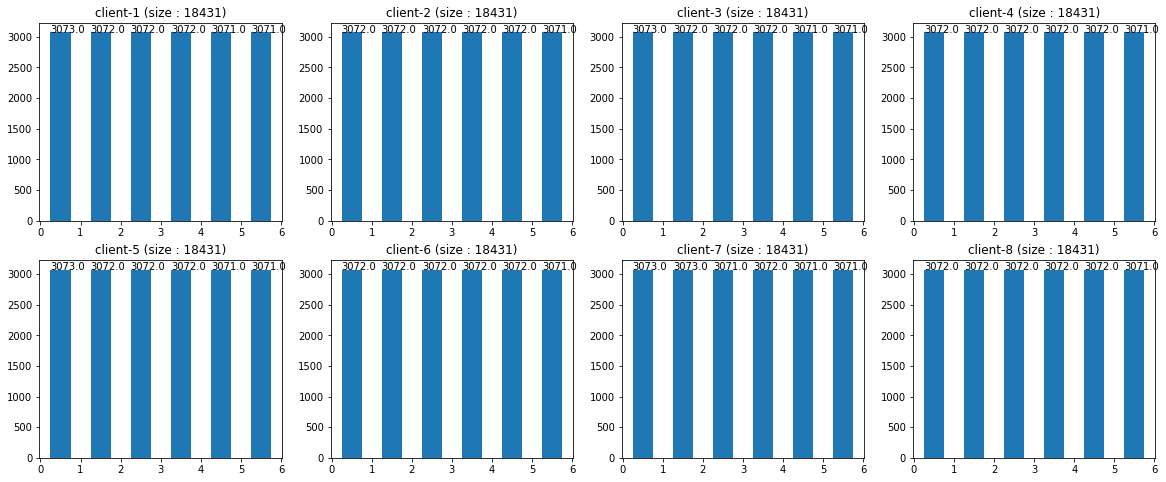

In [27]:
fig, ax = plt.subplots(2,4, figsize=(20,8))
for i,y_client in enumerate(y_client_list):
  ax[int(i/4), i%4].hist(y_client, bins=[0, 1, 2, 3, 4, 5, 6], rwidth=0.5)
  ax[int(i/4), i%4].set_title('client-{} (size : {})'.format(i+1, y_client.shape[0]))
  for p in ax[int(i/4), i%4].patches:
    ax[int(i/4), i%4].annotate(str(p.get_height()), (p.get_x(), p.get_height()))


### Save the preprocessed data before continuing to the training process

In [28]:
# new location of preprocessed data
dataset_dir = work_dir+'preprocessed_data/'

In [29]:
# create folder if not exist
if not os.path.exists(dataset_dir):
  os.mkdir(dataset_dir)

In [24]:
# save train set (all) and test set to csv
np.savetxt(dataset_dir+"X_train.csv", X_train, delimiter=",")
np.savetxt(dataset_dir+"y_train.csv", y_train, delimiter=",")
np.savetxt(dataset_dir+"X_test.csv", X_test, delimiter=",")
np.savetxt(dataset_dir+"y_test.csv", y_test, delimiter=",")

In [30]:
# save client set (the 8 splits) to csv
for i, X_client in tqdm(enumerate(X_client_list)):
  np.savetxt(dataset_dir+"X_client-{}.csv".format(i), X_client, delimiter=",")
  np.savetxt(dataset_dir+"y_client-{}.csv".format(i), y_client_list[i], delimiter=",")

8it [01:04,  8.00s/it]


### Load the previously saved data

In [33]:
# location of preprocessed data
dataset_dir = work_dir+'preprocessed_data/'

In [35]:
X_client_files = glob.glob(dataset_dir+'X_client*.csv')
X_client_files.sort()
y_client_files = glob.glob(dataset_dir+'y_client*.csv')
y_client_files.sort()

X_test_file = dataset_dir+'X_test.csv'
y_test_file = dataset_dir+'y_test.csv'

In [36]:
# A custom dataset to load the saved data
class CustomDataset(Dataset) :
  def __init__(self, input_filename, label_filename):

    df_input = pd.read_csv(input_filename, header=None, dtype=np.float32)
    df_label = pd.read_csv(label_filename, header=None, dtype=np.long)

    self.X = torch.tensor(df_input.values, dtype=torch.float32)
    self.y = torch.tensor(df_label[0].values)
    self.len_data = len(self.y)

  def __len__(self):
    return self.len_data
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

Dataset is loaded using DataLoader

In [37]:
client_loaders = [DataLoader(CustomDataset(input_filename, label_filename), batch_size=batch_size, shuffle=True
                             ) for input_filename, label_filename in tqdm(zip(X_client_files, y_client_files))]

8it [00:08,  1.01s/it]


In [38]:
test_loader = DataLoader(CustomDataset(X_test_file, y_test_file),
                         batch_size=batch_size, shuffle=True)

### Set the device (in case GPU available)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Define the model architecture
Basically there are some models created here, one global model and eight client models. The models are **fully connected deep learning** models.

In [40]:
global_model = nn.Sequential(
      nn.Linear(210, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 6)
      )
global_model = global_model

# create the client model and put it into a single array
client_models = [ nn.Sequential(
      nn.Linear(210, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 6)
      ) for _ in range(n_clients)]

# initialize the state of each client model using global model's state
for i in range(len(client_models)):
  client_models[i].load_state_dict(global_model.state_dict())

# define optimazers for each client model
optims = [torch.optim.Adam(model.parameters(), lr=0.001) for model in client_models]

### Helper functions for training

In [43]:
# this function is used to train each client model
def client_update(client_model, optimizer, client_loader, epoch=5):
  client_model = client_model.to(device)
  client_model.train()
  loss_criterion = nn.CrossEntropyLoss()

  train_data_size = len(client_loader.dataset)
  for e in range(epoch):
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (inputs, labels) in enumerate(client_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = client_model(inputs)
      loss = loss_criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * inputs.size(0)
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      train_acc += acc.item() * inputs.size(0)

    avg_train_loss = train_loss/float(train_data_size)
    avg_train_acc = train_acc/float(train_data_size)
    # print("avg train loss : {} | avg train acc : {}".format(avg_train_loss, avg_train_acc))

  client_model = client_model.to('cpu') # move back to cpu
  return avg_train_loss, avg_train_acc

In [44]:
# this function is used to aggregate (averaging) client's models
def server_aggregate(global_model, client_models):
  global_dict = global_model.state_dict()
  for k in global_dict.keys():
    global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
  for i in range(len(client_models)):
      client_models[i].load_state_dict(global_model.state_dict())

In [45]:
# this function is to test global model on test data
def test(global_model, test_loader):
  global_model = global_model.to(device)
  global_model.eval()
  test_loss = 0
  correct = 0
  loss_criterion = nn.CrossEntropyLoss(reduction='sum')
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = global_model(inputs)
      test_loss +=loss_criterion(outputs, labels).item()
      pred = outputs.argmax(dim=1, keepdim=True)
      correct += pred.eq(labels.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  global_model = global_model.to('cpu')
  return test_loss, acc

### Training
Basically following the same idea with the above Federation Averaging pseudo-code. Here I use all 8 clients in the training process instead of some fraction of clients. Or we can say I'm using C=1.

In [46]:
avg_train_losses = []
test_losses = []
avg_train_accs = []
test_accs = []

for r in range(n_rounds):
  print('\n%d-th round' % (r+1))

  train_loss = 0
  train_acc = 0
  for i in tqdm(range(n_clients), file=sys.stdout):
    # client update
    loss, acc = client_update(client_models[i], optims[i], client_loaders[i], epoch=epochs)
    train_loss += loss
    train_acc += acc

  avg_train_loss = train_loss / n_clients
  avg_train_acc = train_acc / n_clients

  avg_train_losses.append(avg_train_loss)
  avg_train_accs.append(avg_train_acc)

  # aggregate client's model
  server_aggregate(global_model, client_models)
  
  test_loss, test_acc = test(global_model, test_loader)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  
  print('avg train loss %0.3g | avg train acc %0.3g | test loss %0.3g | test acc: %0.3f' % (avg_train_loss, avg_train_acc, test_loss, test_acc))



1-th round
100%|██████████| 8/8 [00:27<00:00,  3.44s/it]
avg train loss 0.188 | avg train acc 0.935 | test loss 0.0613 | test acc: 0.992

2-th round
100%|██████████| 8/8 [00:27<00:00,  3.39s/it]
avg train loss 0.0367 | avg train acc 0.99 | test loss 0.00765 | test acc: 0.998

3-th round
100%|██████████| 8/8 [00:27<00:00,  3.39s/it]
avg train loss 0.0177 | avg train acc 0.996 | test loss 0.00432 | test acc: 0.999

4-th round
100%|██████████| 8/8 [00:27<00:00,  3.40s/it]
avg train loss 0.00867 | avg train acc 0.998 | test loss 0.00265 | test acc: 0.999

5-th round
100%|██████████| 8/8 [00:27<00:00,  3.39s/it]
avg train loss 0.00915 | avg train acc 0.998 | test loss 0.00268 | test acc: 0.999

6-th round
100%|██████████| 8/8 [00:26<00:00,  3.34s/it]
avg train loss 0.0103 | avg train acc 0.998 | test loss 0.00273 | test acc: 0.999

7-th round
100%|██████████| 8/8 [00:27<00:00,  3.44s/it]
avg train loss 0.01 | avg train acc 0.998 | test loss 0.00251 | test acc: 1.000


### Visualize the training results

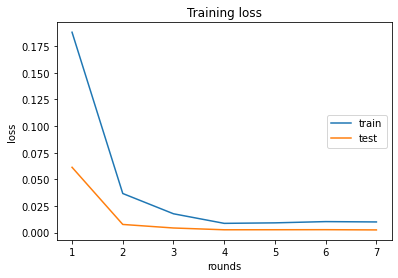

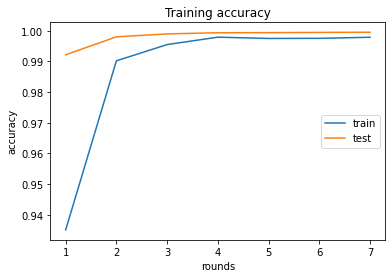

In [47]:
x = np.arange(1, len(avg_train_losses)+1)

plt.plot(x,avg_train_losses, label = "train")
plt.plot(x,test_losses, label = "test")
plt.xlabel('rounds')
plt.ylabel('loss')
plt.title('Training loss')
plt.legend(loc="center right")
plt.show()

plt.plot(x,avg_train_accs, label = "train")
plt.plot(x,test_accs, label = "test")
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.title('Training accuracy')
plt.legend(loc="center right")
plt.show()

## Evaluation on test set
Here, I collect the predictions to display the classification report (including f1score, precision, recall & accuracy), and also to display the confusion matrix.

The evaluation result is quite satisfying with around **0.999%** for the accuracy, precision, recall, and f1 score.

In [49]:
global_model = global_model.to('cpu')
global_model.eval()

test_loss = 0
correct = 0
all_preds = []
all_labels = []

loss_criterion = nn.CrossEntropyLoss(reduction='sum')
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs = inputs.to('cpu')
    labels = labels.to('cpu')
    outputs = global_model(inputs)
    test_loss +=loss_criterion(outputs, labels).item()  # sum up batch loss
    pred = outputs.argmax(dim=1, keepdim=True)

    all_preds.extend(pred.tolist())
    all_labels.extend(labels.tolist())

In [56]:
print(classification_report(all_labels, all_preds, digits=7))

              precision    recall  f1-score   support

           0  0.9998373 0.9998373 0.9998373      6145
           1  0.9998372 0.9993490 0.9995930      6144
           2  0.9990244 1.0000000 0.9995120      6144
           3  1.0000000 0.9986979 0.9993485      6144
           4  0.9991862 0.9993489 0.9992675      6143
           5  0.9993492 1.0000000 0.9996745      6142

    accuracy                      0.9995388     36862
   macro avg  0.9995390 0.9995388 0.9995388     36862
weighted avg  0.9995391 0.9995388 0.9995388     36862




------------ Confusion Matrix ------------


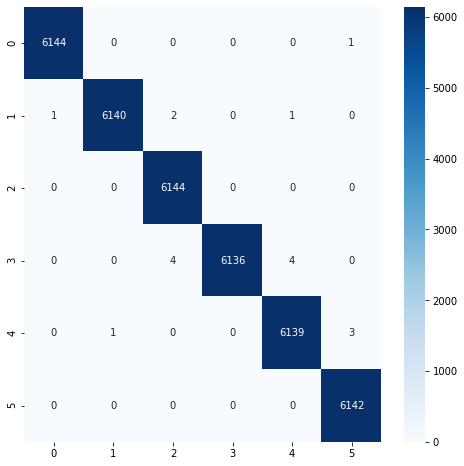

In [51]:
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(0,6))

print('\n------------ Confusion Matrix ------------')

df_cm = pd.DataFrame(cm, index = np.arange(0,6),
                  columns = np.arange(0,6))
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.show()